In [5]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import pyramid_gaussian

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 1.0, 'Moving Image')

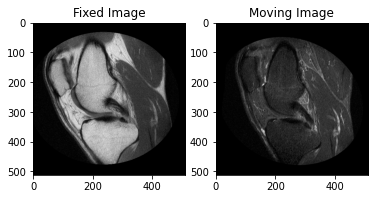

In [6]:
from google.colab import drive
drive.mount('/content/drive')

I = io.imread("/content/drive/My Drive/MM803/Assignment2/knee1.bmp").astype(np.float32)/255.0 # fixed image
J = io.imread("/content/drive/My Drive/MM803/Assignment2/knee2.bmp").astype(np.float32)/255.0 # moving image

nChannel = 1 # gray scale image

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I,cmap="gray")
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J,cmap="gray")
plt.title("Moving Image")
  

In [7]:
L = 6 # Gaussian pyramid level
downscale = 2.0 # downscale factor for the gaussian pyramid
pyramid_I = tuple(pyramid_gaussian(I, downscale=downscale, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(J, downscale=downscale, multichannel=False))

nFraction=0.1 # fraction of pixels used in MINE calculation

# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in range(L):
  I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
  I_lst.append(I_)
  J_lst.append(J_)
  h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]
  ind_ = torch.randperm(h_*w_)[0:int(nFraction*h_*w_)].to(device)
  ind_lst.append(ind_)

  print(h_,w_,len(ind_))
  h_lst.append(h_)
  w_lst.append(w_)

  y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
  y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
  xy_ = torch.stack([x_,y_],2)
  xy_lst.append(xy_)


512 512 26214
256 256 6553
128 128 1638
64 64 409
32 32 102
16 16 25


In [9]:
class HomographyNet(nn.Module):
  def __init__(self):
    super(HomographyNet, self).__init__()
    # perspective transform basis matrices

    self.B = torch.zeros(8,3,3).to(device)
    self.B[0,0,2] = 1.0
    self.B[1,1,2] = 1.0
    self.B[2,0,1] = 1.0
    self.B[3,1,0] = 1.0
    self.B[4,0,0], self.B[4,1,1] = 1.0, -1.0
    self.B[5,1,1], self.B[5,2,2] = -1.0, 1.0
    self.B[6,2,0] = 1.0
    self.B[7,2,1] = 1.0

    self.v = torch.nn.Parameter(torch.zeros(8,1,1).to(device), requires_grad=True)

  def forward(self):
    return MatrixExp(self.B,self.v)

def MatrixExp(B,v):
    C = torch.sum(B*v,0)
    A = torch.eye(3).to(device)
    H = torch.eye(3).to(device)
    for i in torch.arange(1,10):
        A = torch.mm(A/i,C)
        H = H + A
    return H    

In [10]:
n_neurons = 100
class MINE(nn.Module): #https://arxiv.org/abs/1801.04062
  def __init__(self):
    super(MINE, self).__init__()
    self.fc1 = nn.Linear(2*nChannel, n_neurons)
    self.fc2 = nn.Linear(n_neurons, n_neurons)
    self.fc3 = nn.Linear(n_neurons, 1)

  def forward(self, x, ind):
    
    x = x.view(x.size()[0]*x.size()[1],x.size()[2])
    z1 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x[ind,:])))))
    for i in range(500):
      ind_perm = ind[torch.randperm(len(ind))]
      z2 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(torch.cat((x[ind,0:nChannel],x[ind_perm,nChannel:2*nChannel]),1))))))
      MI = torch.mean(z1) - torch.log(torch.mean(torch.exp(z2)))
    return MI

In [11]:
def PerspectiveWarping(I, H, xv, yv):

  # apply transformation in the homogeneous coordinates
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J

In [12]:
def multi_resolution_MINE_loss():
  loss=0.0
  for s in np.arange(L-1,-1,-1):
    Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0).unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
    mi = mine_net(torch.stack([I_lst[s],Jw_],2),ind_lst[s])
    loss = loss - (1./L)*mi
  return loss

In [13]:
homography_net = HomographyNet().to(device)

mine_net = MINE().to(device)
optimizer = optim.Adam([{'params': mine_net.parameters(), 'lr': 1e-2},
                        {'params': homography_net.v, 'lr': 1e-2}], amsgrad=True)

for itr in range(100):
  optimizer.zero_grad()
  loss = multi_resolution_MINE_loss()
  if itr%10 == 0:
    print("Itr:",itr,"MINE value:","{:.4f}".format(-loss.item()))
  loss.backward()
  optimizer.step()
print("Itr:",itr+1,"MINE value:","{:.4f}".format(-loss.item()))

Itr: 0 MINE value: -0.0012
Itr: 10 MINE value: 0.1453
Itr: 20 MINE value: 0.4425
Itr: 30 MINE value: 0.6118
Itr: 40 MINE value: 0.7155
Itr: 50 MINE value: 0.6349
Itr: 60 MINE value: 0.6396
Itr: 70 MINE value: 0.7388
Itr: 80 MINE value: 0.7391
Itr: 90 MINE value: 0.7543
Itr: 100 MINE value: 0.8312


Mutual information before registration: 0.5551
Mutual information after registration: 0.8553
Transformation matrix:
[[ 0.9800823  -0.09684478  0.04935605]
 [ 0.18691523  0.96906793  0.05524996]
 [-0.00854595  0.00467374  1.0329461 ]]



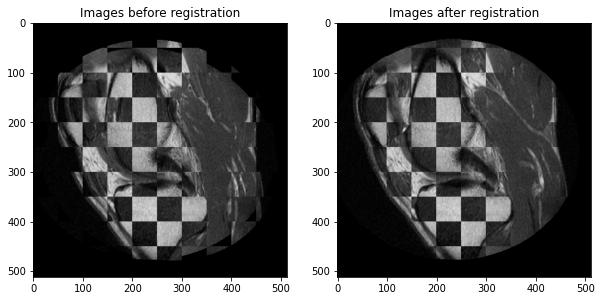

In [14]:
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

I_t = torch.tensor(I).to(device)
J_t = torch.tensor(J).to(device)
H = homography_net()
J_w = PerspectiveWarping(J_t.unsqueeze(0).unsqueeze(0), H , xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze()

D = J_t - I_t
D_w = J_w - I_t

print("Mutual information before registration:", "{:.4f}".format(histogram_mutual_information(I,J)))
print("Mutual information after registration:", "{:.4f}".format(histogram_mutual_information(I,J_w.cpu().detach().numpy())))

print("Transformation matrix:")
print(H.cpu().detach().numpy())
print("")

Ra = I_t.clone()
Rb = I_t.clone()
b = 50
for i in torch.arange(0,I_t.shape[0]/b,1).int():
  for j in torch.arange(i%2,np.floor(I_t.shape[1]/b),2).int():
    Rb[i*b:(i+1)*b,j*b:(j+1)*b] = J_t[i*b:(i+1)*b,j*b:(j+1)*b].clone()
    Ra[i*b:(i+1)*b,j*b:(j+1)*b] = J_w[i*b:(i+1)*b,j*b:(j+1)*b].clone()
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(Rb.cpu().data,cmap="gray")
plt.title("Images before registration")
fig.add_subplot(1,2,2)
plt.imshow(Ra.cpu().data,cmap="gray")         
plt.title("Images after registration")
plt.show()